# MFT predictions of number of active tunings vs D

$$\lambda_{max} = \frac{D}{D-1} \bigg[ A\Lambda_2 \left(D, \frac{\mu_0 - \mu_1}{\sqrt{D}} + \sqrt{D}\mu_1, \sqrt{\frac{\sigma_0^2-\sigma_1^2}{D} + \sigma_1^2} \right) 
    + B\Lambda_1 \left(D, \frac{\mu_0 - \mu_1}{\sqrt{D}} + \sqrt{D}\mu_1, \sqrt{\frac{\sigma_0^2 -\sigma_1^2}{D} + \sigma_1^2} \right) + C/D \bigg]$$

Mean-driven example: when $\mu_0 > 0, \mu_1 = 0, \sigma_0 = \sigma_1 = 1$, then $K = 1$ if $D \leq D_{\mu}^*$ and $K = D$ if $D > D_{\mu}^*$, where e.g. $D_{\mu}^* = 4$ for $\mu_0 = 1.5$.

Fluctuation-driven example: when $\mu_0 = \mu_1 = \sigma_1 = 0$ but $\sigma_0 = 1$ then $K = D$ if $D \leq D_{\sigma}^*$ and $K = D^*$ if $D > D_{\sigma}^*$, where $D_{\sigma}^* = 10$.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from disp import set_plot

# Finite MFT simulations

In [ ]:
NTR = 9
N = 3000

In [2]:
# numeric params for computing MF quantities
DX = .01
X_MIN = -100
X_MAX = 100

X = np.linspace(X_MIN, X_MAX, int((X_MAX-X_MIN)/DX)+1)

def norm(x, mu, sgm):
    if sgm == 0:
        temp = np.zeros(X.shape)
        temp[np.argmin(np.abs(X))] = 1/DX
        return temp
    
    return stats.norm.pdf(x, loc=mu, scale=sgm)

def phi(x, mu, sgm):
    if sgm == 0:
        temp = (X >= 0).astype(float)
        temp[X == 0] = .5
        return temp
    
    return stats.norm.cdf(x, loc=mu, scale=sgm)

def alph(th, u, v, D, mu_j, sgm_j, N=np.inf):
    """
    th \in [0, 1]^D
    u \in R^D
    v \in R_+^D
    D scalar
    mu_j \in R^{DxD}
    sgm_j \in R^{DxD}
    """
    mu_d = D*(mu_j @ th) + u
    sgm_d = np.sqrt(D*((sgm_j**2)@th) + v)
    
    phis = np.array([phi(X, mu_d_, sgm_d_) for mu_d_, sgm_d_ in zip(mu_d, sgm_d)])
    
    mnot_d = ~np.eye(len(th), dtype=bool) # masks for selecting all but one d
    
    th_next = np.nan*np.zeros(D)
    for d, (mu_d_, sgm_d_) in enumerate(zip(mu_d, sgm_d)):
        
        mask_d = mnot_d[d]
        th_next[d] = min(np.sum(norm(X, mu_d_, sgm_d_) * np.prod(phis[mask_d, :], axis=0))*DX, 1)
        
    if np.isinf(N):
        return th_next
    else:
        return np.random.multinomial(N, th_next)/N

In [3]:
def get_active(ths, t_1):
    ths_mn = ths[t_1:, :].mean(0)  # ppln time average
    matv = ths_mn > np.max(ths_mn/2)  # mask over active labels
    iatv = matv.nonzero()[0]  # idxs of active labels
    return iatv

## Mean-driven simulation

Here we use $\mu_0 = 1.5$.

In [4]:
t_max = 100

mu_0_md = 1.5
mu_1_md = 0
sgm_0_md = 1
sgm_1_md = 1

ths_alls = []

DS = np.arange(2, 20)

for D in DS:

    mu_j = np.nan*np.zeros((D, D))
    mu_j[np.eye(D, dtype=bool)] = mu_0_md
    mu_j[~np.eye(D, dtype=bool)] = mu_1_md

    sgm_j = np.nan*np.zeros((D, D))
    sgm_j[np.eye(D, dtype=bool)] = sgm_0_md
    sgm_j[~np.eye(D, dtype=bool)] = sgm_1_md

    sys.stdout.write('.')

    ths_all = []
    
    for ctr in range(NTR):
        th_0 = 1 + .05*np.random.randn(D)
        th_0 /= th_0.sum()

        ths = np.nan*np.zeros((t_max, D))
        ths[0, :] = th_0

        for t_ in range(1, t_max):
            ths[t_, :] = alph(ths[t_-1, :], u=0, v=0, D=D, mu_j=mu_j, sgm_j=sgm_j, N=N)

        ths_all.append(ths)
        
    ths_alls.append(ths_all)

..................

In [5]:
q_med_mds = []
for ths_all in ths_alls:
    q_med_md = np.median([len(get_active(ths, t_max//2)) for ths in ths_all])
    q_med_mds.append(q_med_md)

print('MED(Q) =', q_med_mds)

MED(Q) = [1.0, 1.0, 1.0, 1.0, 1.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0]


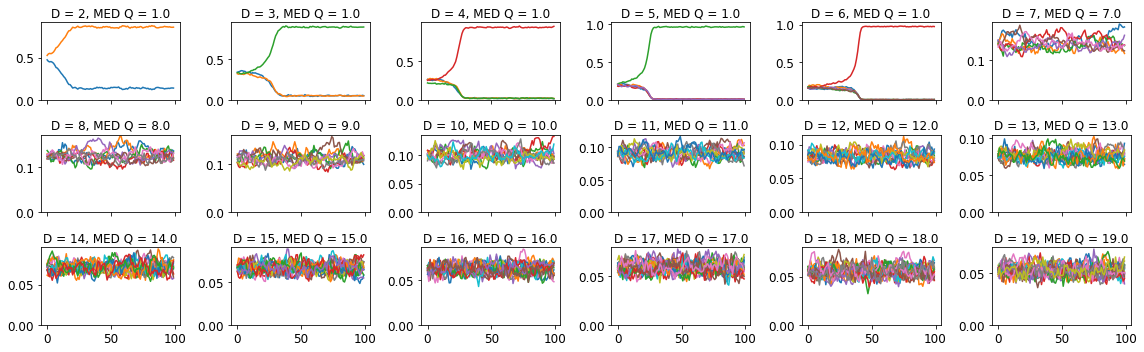

In [6]:
fig, axs = plt.subplots(3, 6, figsize=(16, 5), tight_layout=True, sharex=True)
for ax, D, ths_all, q_med_md in zip(axs.flat, DS, ths_alls, q_med_mds):
    ths = ths_all[0]
    ax.plot(ths)
    ax.set_ylim(bottom=0)
    set_plot(ax, title=f'D = {D}, MED Q = {q_med_md}')

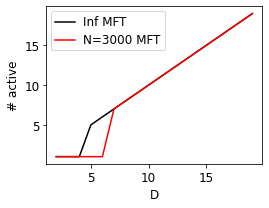

In [7]:
D_STAR_MU = 4  # for mu_0 = 1.5 only
q_med_md_infs = [1 if D <= D_STAR_MU else D for D in DS]

fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
ax.plot(DS, q_med_md_infs, c='k')
ax.plot(DS, q_med_mds, c='r')
ax.legend(['Inf MFT', f'N={N} MFT'])
set_plot(ax, x_label='D', y_label='# active')

## Fluctuation-driven simulation

In [8]:
t_max = 200

mu_0_fd = 0
mu_1_fd = 0
sgm_0_fd = 1
sgm_1_fd = 0

ths_alls = []
    
DS = np.arange(2, 20)

for D in range(2, 20):

    mu_j = np.nan*np.zeros((D, D))
    mu_j[np.eye(D, dtype=bool)] = mu_0_fd
    mu_j[~np.eye(D, dtype=bool)] = mu_1_fd

    sgm_j = np.nan*np.zeros((D, D))
    sgm_j[np.eye(D, dtype=bool)] = sgm_0_fd
    sgm_j[~np.eye(D, dtype=bool)] = sgm_1_fd

    sys.stdout.write('.')

    ths_all = []
    
    for ctr in range(NTR):
        th_0 = 1 + .01*np.random.randn(D)
        th_0 /= th_0.sum()

        ths = np.nan*np.zeros((t_max, D))
        ths[0, :] = th_0

        for t_ in range(1, t_max):
            ths[t_, :] = alph(ths[t_-1, :], u=0, v=0, D=D, mu_j=mu_j, sgm_j=sgm_j, N=N)

        ths_all.append(ths)
        
    ths_alls.append(ths_all)

..................

In [9]:
q_med_fds = []
for ths_all in ths_alls:
    q_med_fd = np.median([len(get_active(ths, t_max//2)) for ths in ths_all])
    q_med_fds.append(q_med_fd)

print('MED(Q) =', q_med_fds)

MED(Q) = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0]


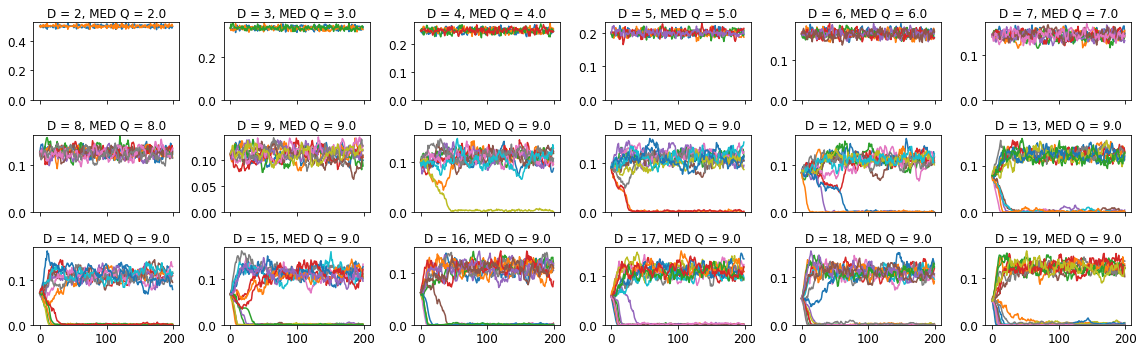

In [10]:
fig, axs = plt.subplots(3, 6, figsize=(16, 5), tight_layout=True, sharex=True)
for ax, D, ths_all, q_med_fd in zip(axs.flat, DS, ths_alls, q_med_fds):
    ths = ths_all[0]
    ax.plot(ths)
    ax.set_ylim(bottom=0)
    set_plot(ax, title=f'D = {D}, MED Q = {q_med_fd}')

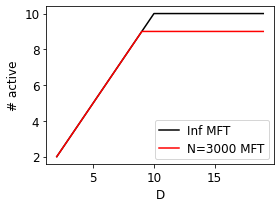

In [11]:
D_STAR_SGM = 10
q_med_fd_infs = [D if D <= D_STAR_SGM else D_STAR_SGM for D in DS]

fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
ax.plot(DS, q_med_fd_infs, c='k')
ax.plot(DS, q_med_fds, c='r')
ax.legend(['Inf MFT', f'N={N} MFT'])
set_plot(ax, x_label='D', y_label='# active')

# Save

In [13]:
np.save('data/multistability/n_active_mft.npy', np.array([{
    'DS': DS,
    'N': N,
    'q_med_mds_fin': q_med_mds,
    'q_med_mds_inf': q_med_md_infs,
    'q_med_fds_fin': q_med_fds,
    'q_med_fds_inf': q_med_fd_infs,
}]))